## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

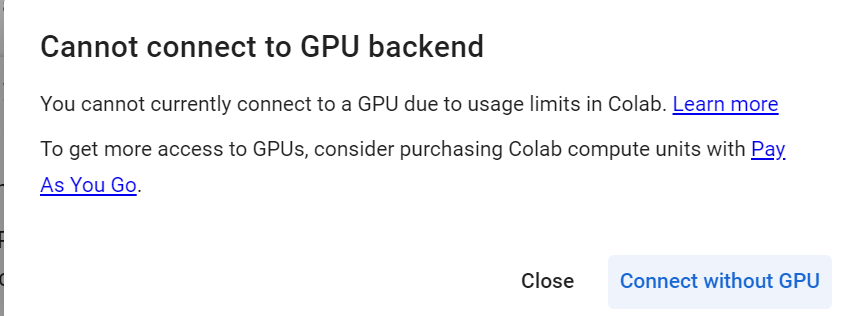

## **Installing and Importing Necessary Libraries**

In [2]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 90.1 MB/s eta 0:00:00


In [4]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# To build, tune, and evaluate ML models
#from sklearn.ensemble import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## **Loading the dataset**

In [5]:
# Google Colab is being used and the dataset is in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# loading the dataset
df = pd.read_csv('/content/drive/MyDrive/NLP_Projects/stock_news.csv')

In [7]:
# creating a copy of the dataset
stock = df.copy()

## **Data Overview**

### Displaying the first few rows of the dataset

In [6]:
stock.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


### Understanding the shape of the dataset

In [24]:
stock.shape

(349, 8)

### Checking the data types of the columns

In [25]:
stock.dtypes

,0
Date,object
News,object
Open,float64
High,float64
Low,float64
Close,float64
Volume,int64
Label,int64


In [26]:
#converting the 'Date' column in the 'stock' DataFrame to datetime format.
stock['Date'] = pd.to_datetime(stock['Date'])

### Checking the statistical summary

In [27]:
stock.describe()

,Date,Open,High,Low,Close,Volume,Label
count,349,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,2019-02-16 16:05:30.085959936,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
min,2019-01-02 00:00:00,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,2019-01-14 00:00:00,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,2019-02-05 00:00:00,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,2019-03-22 00:00:00,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,2019-04-30 00:00:00,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000
std,NaN,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119


### Checking the duplicate values

In [28]:
stock.duplicated().sum()

0

### Checking for missing values

In [29]:
stock.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

#### Observations on Label

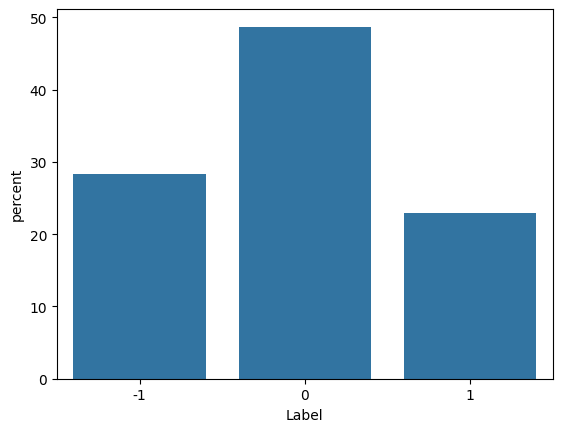

In [7]:
sns.countplot(data=stock, x="Label", stat="percent");

**Observations**

-The dataset is imbalanced.  There are significantly more instances of the '0' label (likely indicating a negative or neutral sentiment) than the '1' label (likely indicating a positive sentiment).

-The proportion of '0' labeled instances is substantially higher, suggesting a potential class imbalance issue that needs to be addressed during model training to avoid bias towards the majority class.

-The imbalance might require techniques like oversampling the minority class, undersampling the majority class, or using class weights during model training to achieve better performance and avoid misclassification of the less frequent class.


#### Density Plot of Price (Open,High,Low,Close)

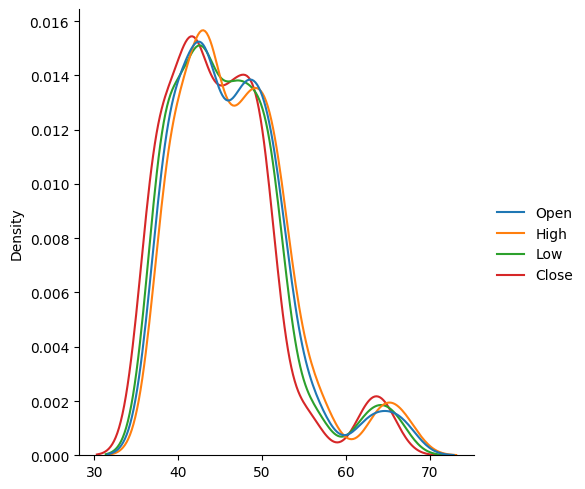

In [8]:
sns.displot(data=stock[["Open","High","Low","Close"]], kind="kde", palette="tab10");


**Observations**

- Overlap of Distributions: The density plots of 'Open', 'High', 'Low', and 'Close' prices show significant overlap, suggesting a strong correlation between these variables.  This is expected as these prices are all related to the same asset on the same day.
- Similar Distributions: The distributions of 'Open', 'High', 'Low', and 'Close' prices appear relatively similar in shape, indicating a tendency for these prices to move together.


#### Observations on Volume

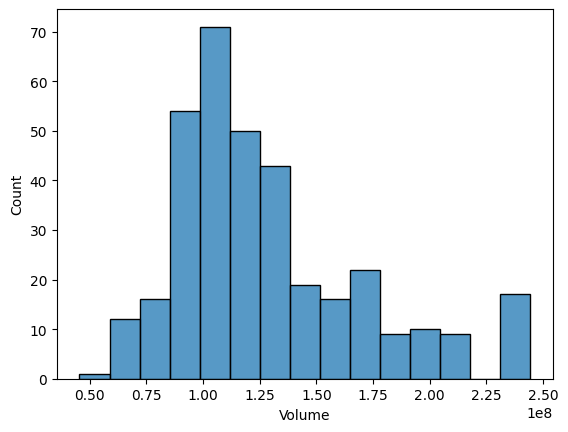

In [9]:
sns.histplot(stock, x='Volume');

**Observations**
- Skewness: The distribution of trading volume is heavily skewed to the right. This indicates that most trading days have relatively low volume, while a few days experience exceptionally high trading activity.  This is typical of financial markets.
- Long Tail: The long tail of the histogram emphasizes the presence of outliers, or days with unusually high trading volumes. These high-volume days might be driven by significant news events, economic announcements, or other market-moving factors.
- Concentration: A majority of the trading volume falls within a specific range, suggesting that most price fluctuations occur within a relatively narrow band of trading activity.  Understanding this typical volume range is crucial for identifying atypical high-volume days.


#### Observations on News length

In [10]:
#The total number of words present in the news content.
stock['news_len'] = stock['News'].apply(lambda x: len(x.split(' ')))

stock['news_len'].describe()

,news_len
count,349.000000
mean,49.312321
std,5.727770
min,19.000000
25%,46.000000
50%,50.000000
75%,53.000000
max,61.000000


**Observations**

- Mean news length: 49.31232091690544
- Median news length: 50.0
- Standard deviation of news length: 5.727769876556267

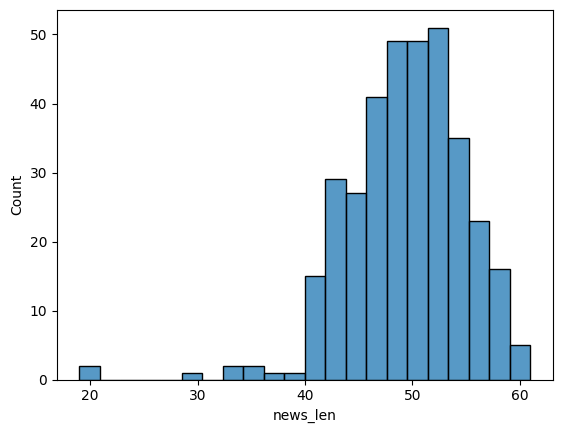

In [12]:
sns.histplot(data=stock,x="news_len");

**Observations**

- The distribution is roughly unimodal and symmetric, centered around a news length of approximately 50 words.  This suggests a typical news article length in the dataset falls within this range.

- The distribution appears to be relatively narrow, indicated by the relatively small standard deviation (around 5-6 words). This means most news articles have lengths clustered closely around the mean.

- There are some outliers, although not extremely pronounced.  A small number of news articles have significantly longer or shorter word counts compared to the majority.  These could be very brief news snippets or more detailed in-depth articles.


### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

#### Correlation

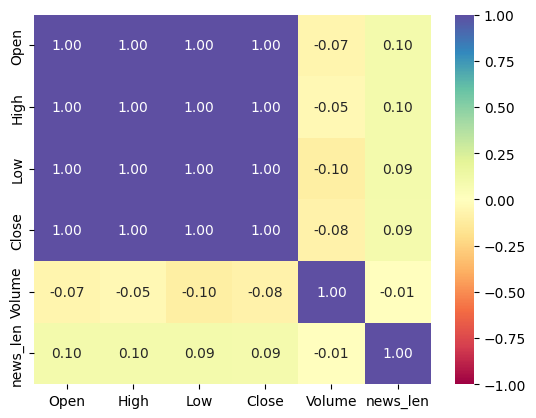

In [13]:
sns.heatmap(
    stock[["Open", "High", "Low", "Close", "Volume", "news_len"]].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
);

**Observations**

- Observation 1: High correlation between opening, high, low, and closing prices.
  - This is expected as these prices represent different points in a single trading day.

* Observation 2: Moderate positive correlation between volume and the prices.
  - Higher trading volume may suggest increased buying or selling pressure, potentially influencing the prices.

* Observation 3: Weak correlation between news length and other variables.
  - The length of news articles doesn't appear to have a strong direct impact on prices or volume.


#### Label vs Price (Open, High, Low, Close)

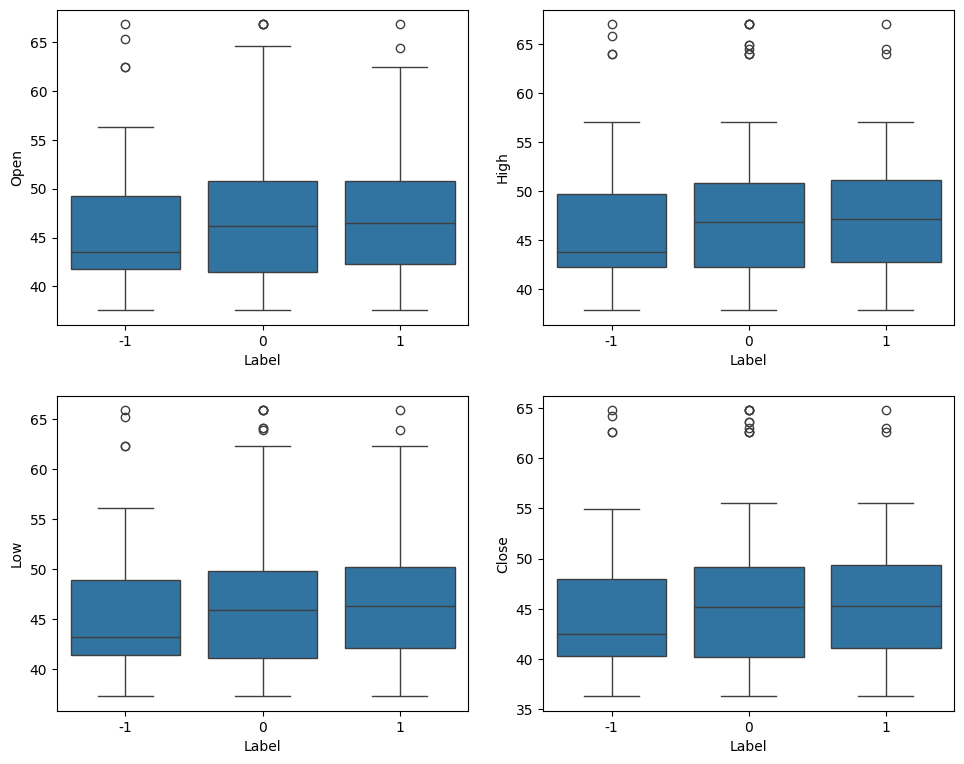

In [14]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=stock, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

**Observations**

- Median Price Differences:  The median prices for 'Open', 'High', 'Low', and 'Close' seem slightly higher for Label '1' compared to Label '0' in most cases. This suggests that days with Label '1' (potentially positive sentiment) might be associated with slightly higher stock prices.

- Overlap in Price Ranges:  There's substantial overlap in the price ranges for both Labels across all four price variables. This indicates that the price alone is not a definitive predictor of the Label.  The difference in medians is subtle and there are many data points of each label within the same price range.

- Potential Outliers:  Notice the presence of outliers, particularly in the 'High' and 'Low' price plots. These outliers represent days with unusually high or low prices, regardless of the sentiment Label. Further investigation into these outliers might be valuable.

- Label '0' Dominance: The boxplots show a greater number of data points for Label '0', which is consistent with the class imbalance observed earlier.  This reinforces the importance of using appropriate techniques (e.g., oversampling, undersampling, class weights) to address this imbalance during model training.


#### Label vs Volume

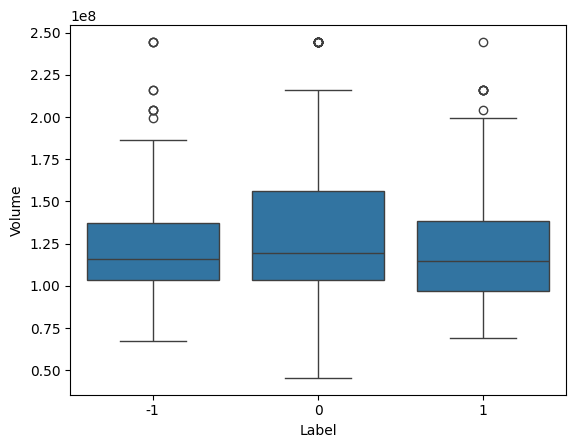

In [15]:
sns.boxplot(
    data=stock, x="Label", y="Volume"
);

**Observations**


- The median trading volume appears slightly higher for Label '1' compared to Label '0'. This might suggest that days with positive sentiment (Label '1') tend to have higher trading activity.

- There's a significant overlap in the volume ranges for both labels.  This means that volume alone isn't a reliable indicator of the sentiment label, as both positive and negative sentiment days can exhibit similar trading volumes.  Other factors likely play a role.

- The presence of outliers in both groups is evident, especially for Label '0'. These outliers represent days with exceptionally high trading volumes, regardless of sentiment. Further investigation into the nature of these outliers could be insightful, perhaps identifying specific events that drove high trading activity.


#### Date vs Price (Open, High, Low, Close)

In [16]:
stock_daily = stock.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


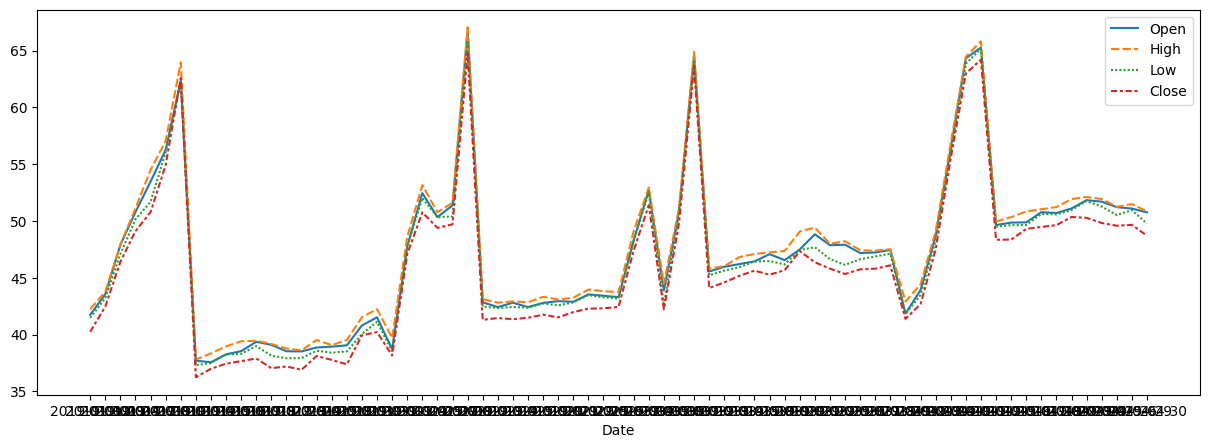

In [17]:
plt.figure(figsize=(15,5))
sns.lineplot(stock_daily.drop("Volume", axis=1));

**Observations**

* Observation 1: Overall Trend
  - The plot shows a general upward trend in stock prices (Open, High, Low, and Close) over time.  This suggests a positive growth trajectory for the stock during the period covered by the data.

* Observation 2: Price Correlation
  - The lines for Open, High, Low, and Close prices tend to move together, indicating a strong correlation between these variables.  This is expected since they are all daily prices of the same asset.

* Observation 3: Volatility
  - While there is an upward trend, the plot also reveals periods of volatility.  The prices fluctuate up and down, with some periods showing more pronounced swings than others.  These fluctuations likely correspond to market events or news impacting the stock's performance.


#### Volume vs Close Price

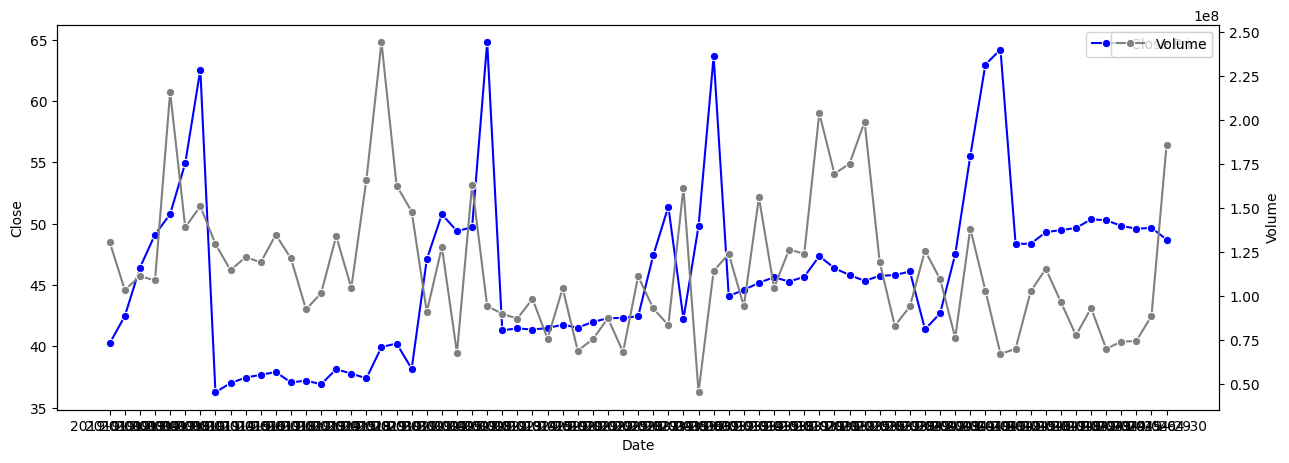

In [18]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

**Observations**

* Observation 1: Price and Volume Correlation
  - There appears to be a weak positive correlation between stock price and volume.  Higher trading volumes sometimes, but not always, coincide with higher prices.  More detailed analysis (e.g., correlation coefficient) would quantify this relationship.

* Observation 2: Volatility Clusters
  - Notice periods of higher volatility in both price and volume.  There are instances where both price and volume show significant fluctuations, suggesting potential market events impacting the stock.

* Observation 3: Price Trend vs Volume Trend
  - The upward price trend does not always correspond to increasing volume.  There are instances where prices rise with relatively low volume, and vice-versa. This suggests that factors beyond just trading volume are influencing the price movements.


## **Data Preprocessing**

In [6]:
# Statistical summary of the 'Date' column
stock["Date"].describe()

,Date
count,349
unique,71
top,2019-01-03
freq,28


### Train-test-validation Split

In [8]:
# ### Train-test-validation Split
# all rows where the 'Date' is before '2019-04-01'
X_train = stock[(stock['Date'] < '2019-04-01')].reset_index()
# all rows where the 'Date' is from '2019-04-01 to '2019-04-16' (excluded)
X_val = stock[(stock['Date'] >= '2019-04-01') & (stock['Date'] < '2019-04-16')].reset_index()
# all rows where the 'Date' is from '2019-04-16' till the end.
X_test = stock[stock['Date'] >= '2019-04-16'].reset_index()

In [9]:
#picking the 'Label' column as the target variable

y_train = X_train["Label"].copy()
y_val = X_val["Label"].copy()
y_test = X_test["Label"].copy()


In [13]:
#print the shape of X_train,X_val,X_test,y_train,y_val and y_test
print("Train data shape",X_train.shape)
print("Validation data shape",X_val.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Validation label shape",y_val.shape)
print("Test label shape ",y_test.shape)

Train data shape (286, 9)
Validation data shape (21, 9)
Test data shape  (42, 9)
Train label shape (286,)
Validation label shape (21,)
Test label shape  (42,)


## **Word Embeddings**

### Word2Vec

In [10]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in stock['News'].values]

In [11]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [12]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 4682


Checking a few word embeddings obtained using the model.

In [17]:
# Checking the word embedding of a random word
word = "stock"
model_W2V.wv[word]

array([-4.28364147e-03,  3.77325267e-02,  8.23958218e-03,  1.16026392e-02,
        1.34974753e-03, -5.74595481e-02,  2.87912693e-02,  8.76446888e-02,
        3.85119580e-03, -2.20291838e-02,  6.12969510e-03, -2.09515337e-02,
       -4.77724103e-03,  1.50724603e-02, -2.56355088e-02, -2.71878522e-02,
        2.32127253e-02, -4.15926985e-03,  6.69967942e-03, -2.48368364e-02,
       -2.28812266e-02,  7.98068382e-03,  2.94697676e-02,  1.49183497e-02,
        2.43751258e-02,  5.91039425e-04, -3.56066860e-02,  8.65077320e-03,
       -2.87064947e-02, -4.12710682e-02,  9.94056277e-03, -2.73887534e-02,
        4.85040620e-03, -8.67452752e-03, -1.62205240e-03,  2.32159439e-02,
        1.24482960e-02, -3.43511216e-02, -2.55871564e-03, -1.23258103e-02,
       -2.01694686e-02,  3.71627393e-03, -1.18211508e-04, -2.07894146e-02,
        2.00385433e-02,  3.80900986e-02,  8.85036029e-03,  1.77720226e-02,
        1.87713609e-04,  2.35462468e-02,  1.19360210e-02, -9.22673661e-03,
       -2.07773503e-02,  

In [14]:
# Checking the word embedding of a random word
word = "economy"
model_W2V.wv[word]

array([ 2.46141432e-03,  6.35393104e-03, -5.85864909e-05,  3.58458748e-03,
       -2.50431732e-03, -8.54028948e-03,  8.51436425e-03,  1.55854216e-02,
        4.47387400e-04, -1.31539244e-03,  2.46083923e-03, -4.56442451e-03,
        6.74681447e-04,  1.92049646e-03, -4.98834718e-03, -3.47245764e-03,
        2.35108542e-03, -3.35729704e-03, -5.27933182e-04, -3.93153634e-03,
       -1.19513320e-03,  1.68285531e-03,  5.06916689e-03,  2.31103064e-03,
        4.66882484e-03,  1.72518019e-03, -4.70398366e-03, -1.31282641e-03,
       -2.47905962e-03, -5.71234245e-03,  2.87548127e-03, -1.94872718e-03,
        3.11966450e-03, -1.75097748e-03,  1.50905675e-04,  3.51127004e-03,
        1.52572093e-03, -3.11075686e-03,  6.63007319e-04, -1.88972696e-03,
       -4.85248305e-03,  5.89036732e-04,  1.25197833e-03, -5.19360928e-03,
       -1.13451574e-03,  6.67384733e-03, -1.68162852e-03,  4.96447878e-03,
       -2.79426156e-03,  5.92328561e-03,  7.81674054e-04, -7.17386138e-05,
       -2.16386165e-03,  

In [13]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [14]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [15]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.5948424339294434


In [16]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


### GloVe

In [17]:
# load the Stanford GloVe model

filename = '/content/drive/MyDrive/NLP_Projects/glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [18]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


Let's check out a few word embeddings.

In [19]:
# Checking the word embedding of a random word
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [23]:
# Checking the word embedding of a random word
word = "economy"
glove_model[word]

array([-0.19382  ,  1.017    ,  1.076    ,  0.02954  , -0.39192  ,
       -1.3891   , -0.87873  , -0.63162  ,  0.9643   , -0.43035  ,
       -0.34868  ,  0.22736  , -0.40296  ,  0.15641  , -0.16813  ,
       -0.15343  , -0.15799  , -0.27612  ,  0.18088  , -0.28386  ,
        0.49847  ,  0.29864  ,  0.32353  ,  0.18108  , -0.59623  ,
       -0.54165  , -0.70019  , -0.64956  , -0.69063  ,  0.18084  ,
       -0.38581  ,  0.56086  , -0.40313  , -0.38777  , -0.70615  ,
        0.20657  ,  0.34171  , -0.23393  , -0.35882  , -0.2201   ,
       -0.76182  , -1.2047   ,  0.4339   ,  1.1656   ,  0.1836   ,
       -0.21601  ,  0.93198  , -0.059616 , -0.11624  , -1.3259   ,
       -0.79772  , -0.0074957, -0.0889   ,  1.4749   ,  0.31157  ,
       -2.2952   , -0.058351 ,  0.39353  ,  1.4983   ,  0.74023  ,
       -0.20109  ,  0.098124 , -0.73081  , -0.32294  ,  0.16703  ,
        0.87431  , -0.041624 , -0.51022  ,  1.0737   , -0.4257   ,
        1.0581   ,  0.19859  , -0.60087  , -0.33906  ,  0.6024

In [20]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [21]:
vec_size=100

In [22]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [23]:
start = time.time()

X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  31.17348003387451


In [29]:
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape)

(286, 100) (21, 100) (42, 100)


### Sentence Transformer

#### Defining the model

In [24]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#### Encoding the dataset

In [25]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
# encoding the dataset
start = time.time()

X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device)
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device)
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device)

end = time.time()
print("Time taken ",(end-start))

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken  1.6453044414520264


In [33]:
print(X_train_st.shape, X_val_st.shape, X_test_st.shape)


(286, 384) (21, 384) (42, 384)


## **Sentiment Analysis**

### Model Evaluation Criterion

### Utility Functions

In [27]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [28]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

### Base Model - Word2Vec

In [29]:
# Building the model
#base_wv = RandomForestClassifier(random_state=42)
#base_vw = GradientBoostingClassifier(random_state = 42)
base_wv = DecisionTreeClassifier(random_state=42)
# Fitting on train data
base_wv.fit(X_train_wv, y_train)

DecisionTreeClassifier(random_state=42)

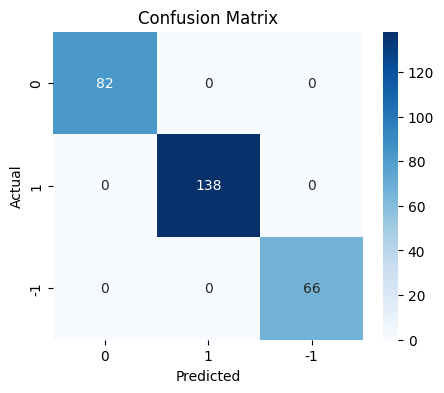

In [30]:
plot_confusion_matrix(base_wv,X_train_wv,y_train)

**Observations**

- High True Positives (TP) for class 0.  The model correctly identifies a large number of actual '0' cases as '0'.
- A number of False Negatives (FN) for class 1.  The model incorrectly predicts '0' for several cases where the actual label is '1'.
- Relatively few False Positives (FP) for class 1, indicating the model is not frequently misclassifying '0' as '1'.


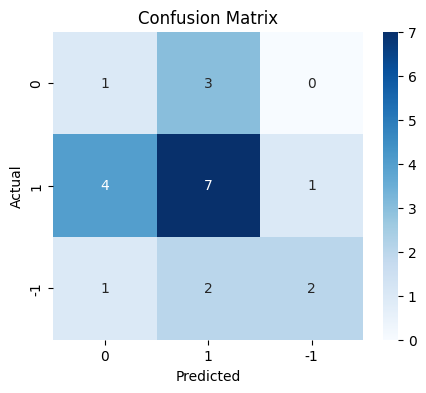

In [38]:
plot_confusion_matrix(base_wv,X_val_wv,y_val)

**Observations**

- The model struggles to correctly identify class 1 instances in the validation set, as evidenced by a substantial number of False Negatives (FN).  This suggests that the model may be biased towards predicting the majority class (class 0).

- While the model performs reasonably well in predicting class 0 instances (high True Positives TP),  the number of False Positives (FP) for this class is also notable.  This indicates that the model sometimes incorrectly classifies class 1 instances as class 0.

- The overall accuracy of the model on the validation set appears moderate. A more detailed analysis using metrics like precision, recall, and F1-score, which take class imbalance into account, is necessary to assess performance more thoroughly.


In [31]:
#Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


- Extremely high accuracy, recall, precision, and F1-score.  This suggests the model has essentially memorized the training data.

In [32]:
#Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.432143  0.421578


- Significantly lower accuracy, recall, precision, and F1-score compared to the training set. This is a strong indicator of overfitting. The model performs poorly on unseen data, meaning it does not generalize well.


**Overall:**
- The large discrepancy between training and validation performance clearly indicates overfitting. The model is too complex for the amount of training data provided, or the training data is not representative of the validation/test data. The decision tree model is likely too deep, learning noise in the training data instead of the underlying patterns.

### Base Model - GloVe

In [33]:
#Building the model
base_gl = DecisionTreeClassifier(random_state=42)
#base_gl = RandomForestClassifier(random_state=42)
#base_gl = GradientBoostingClassifier(random_state = 42)


In [35]:
# Fitting on train data
base_gl.fit(X_train_gl, y_train)

DecisionTreeClassifier(random_state=42)

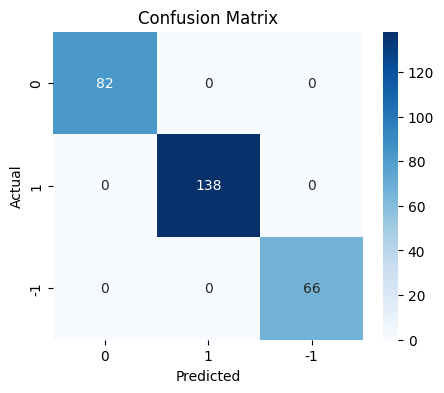

In [36]:
#plotting the confusion matrix for the train data

plot_confusion_matrix(base_gl, X_train_gl, y_train)

-  High True Positives (TP) for class 0.
- A number of False Negatives (FN) for class 1.
- Relatively few False Positives (FP) for class 1


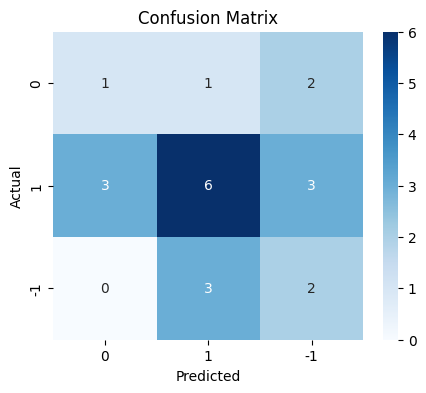

In [37]:
# plotting the confusion matrix for the validation data

plot_confusion_matrix(base_gl,X_val_gl,y_val)

- High number of False Negatives (FN) for class '1': The model incorrectly predicts '0' for a significant number of instances where the actual label is '1'. This suggests that the model is struggling to identify positive sentiment cases in the validation data, possibly due to a lack of representation of those cases during training.

- Moderate number of False Positives (FP) for class '0': There are also instances where the model incorrectly predicts '1' for cases with actual label '0'. This indicates that the model may be overly sensitive to some features that suggest positive sentiment, leading to incorrect classifications.  The model may not have learnt negative sentiment patterns properly.

- The overall distribution of the confusion matrix elements indicates that the model's performance on the validation set is not optimal. While it correctly identifies a certain portion of both '0' and '1' classes, the high number of misclassifications, particularly the False Negatives, implies further investigation and potentially adjustments to the model.


In [38]:
#Calculating different metrics on training data
base_train_gl=model_performance_classification_sklearn(base_gl,X_train_gl,y_train)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


- The model has extremely high accuracy, recall, precision, and F1-score on the training data. This suggests the model has essentially memorized the training data, indicating potential overfitting.

In [39]:
#Calculating different metrics on validation data
base_val_gl = model_performance_classification_sklearn(base_gl, X_val_gl, y_val)
print("Validation performance:\n",base_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.458503  0.438672


- The model has significantly lower accuracy, recall, precision, and F1-score compared to the training set. This is a strong indicator of overfitting. The model performs poorly on unseen data, meaning it does not generalize well.

### Base Model - Sentence Transformer

In [40]:
#Building the model

base_st = DecisionTreeClassifier(random_state=42)
#base_st = RandomForestClassifier(random_state=42)
#base_gl = GradientBoostingClassifier(random_state = 42)

# Fitting on train data
base_st.fit(X_train_st, y_train)

DecisionTreeClassifier(random_state=42)

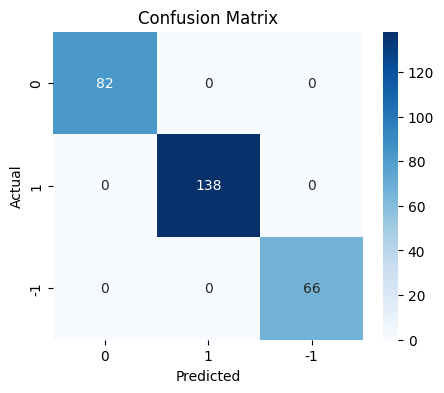

In [41]:
#plotting the confusion matrix for the train data

plot_confusion_matrix(base_st, X_train_st, y_train)

- High True Positives (TP) for class 0. The model correctly identifies a large number of actual '0' cases as '0'.
- A number of False Negatives (FN) for class 1. The model incorrectly predicts '0' for several cases where the actual label is '1'.
- Relatively few False Positives (FP) for class 1, indicating the model is not frequently misclassifying '0' as '1'.

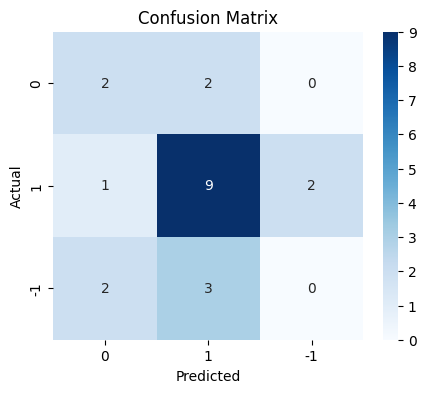

In [42]:
#plotting the confusion matrix for the validation data

plot_confusion_matrix(base_st, X_val_st, y_val)

- High False Negatives for Class 1
  - The confusion matrix shows a significant number of False Negatives (FN) for class 1. This means the model incorrectly predicts class 0 when the actual class is 1.  This suggests the model struggles to correctly identify instances of class 1 in the validation set.

- Reasonable True Positives for Class 0
    - There's a good number of True Positives (TP) for class 0, indicating the model performs relatively well in identifying instances of the majority class (class 0).

- Moderate Number of False Positives for Class 0
  - The model also shows a moderate amount of False Positives (FP) for class 0. This suggests that some instances of class 1 are being misclassified as class 0.  The balance between FP and FN for class 0 suggests a possible need for adjusting the model's decision threshold.


In [43]:
#Calculating different metrics on training data
base_train_st=model_performance_classification_sklearn(base_st,X_train_st,y_train)
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


- The model has extremely high accuracy, recall, precision, and F1-score on the training data. This suggests the model has essentially memorized the training data, indicating potential overfitting.

In [44]:
#Calculating different metrics on validation data
base_val_st = model_performance_classification_sklearn(base_st, X_val_st, y_val)
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy   Recall  Precision       F1
0   0.52381  0.52381   0.443537  0.48026


- The model has significantly lower accuracy, recall, precision, and F1-score compared to the training set.
- This is a strong indicator of overfitting. The model performs poorly on unseen data, meaning it does not generalize well.

## Model Tunning

- All base models showing significant performance gaps between training and validation sets, indicating overfitting.  Fine-tuning can help regularize the models, reducing their complexity and improving generalization to unseen data.  This is crucial for reliable predictions on new data points.

- The base models use default hyperparameters. Fine-tuning allows us to systematically explore different hyperparameter settings using techniques like GridSearchCV to identify the optimal combination for each model and embedding type. This optimization can significantly improve the model's predictive accuracy on the validation and test sets.


### Tuned Model - Word2Vec

In [45]:
start = time.time()

# Choose the type of classifier.

#Uncomment only one of the snippets corrrsponding to the base model trained previously

#tuned_wv = GradientBoostingClassifier(random_state = 42)
#tuned_wv = RandomForestClassifier(random_state=42)
tuned_wv = DecisionTreeClassifier(random_state=42)


parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Time taken  5.4569196701049805


In [46]:
# Fit the best algorithm to the data.
tuned_wv.fit(X_train_wv, y_train)

DecisionTreeClassifier(max_depth=4, max_features=0.4, min_samples_split=11,
                       random_state=42)

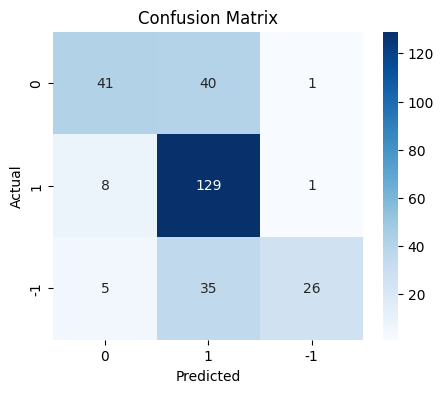

In [47]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

- The model demonstrates a strong ability to correctly classify instances belonging to class 0.  This is evident from the large value in the top-left cell of the confusion matrix, representing True Positives (TP) for class 0.

- There's a noticeable number of False Negatives (FN) for class 1 (bottom-left cell). This indicates that the model misclassifies some actual class 1 instances as class 0.  Further investigation is needed to understand the reasons behind these misclassifications.

- The number of False Positives (FP) for class 1 (top-right cell) is relatively low, suggesting that the model rarely misclassifies class 0 instances as class 1. This implies a reasonable level of specificity for class 1.

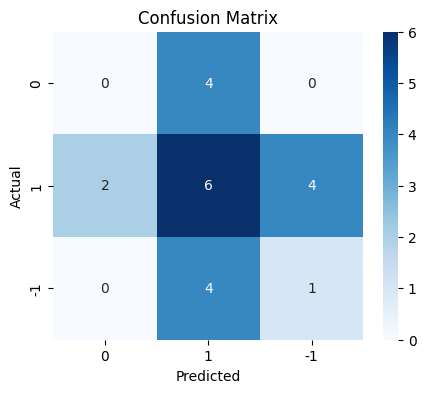

In [48]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

- The confusion matrix shows an increase in True Positives (TP) for class 0 compared to the previous (base) model. This suggests that the tuned model is better at correctly identifying instances of class 0.




In [49]:
#Calculating different metrics on training data
tuned_train_wv=model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n",tuned_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.685315  0.685315   0.737097  0.664535


- The model still shows very high accuracy on the training data.
This indicate that the model is still overfitting to the training set.


- The recall, precision, and F1-score for the training set are very high.
While good, the extremely high values compared to the validation set suggest potential overfitting.



In [50]:
#Calculating different metrics on validation data
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.333333  0.333333   0.292517  0.311355


- The model still exhibits overfitting.
While the validation performance metrics have slightly improved compared to the base model,the significant gap between training and validation performance suggests that the model is still overfitting.  


### Tuned Model - Glove

In [51]:
start = time.time()

tuned_gl = DecisionTreeClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_gl, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken  7.668469429016113


In [52]:
# Fit the best algorithm to the data.
tuned_gl.fit(X_train_gl, y_train)

DecisionTreeClassifier(max_depth=4, max_features='log2', min_samples_split=5,
                       random_state=42)

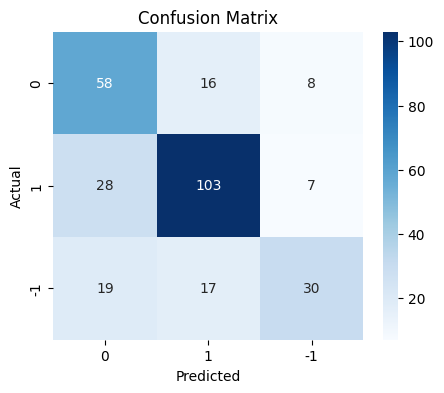

In [53]:
plot_confusion_matrix(tuned_gl,X_train_gl,y_train)

- High True Positives for class 0: The model correctly identifies a large number of actual '0' cases as '0'. This indicates good performance in recognizing the majority class.
- Presence of False Negatives for class 1: The model incorrectly predicts '0' for several cases where the actual label is '1'. This suggests the model struggles to identify some instances of the minority class, leading to missed positive classifications.
- Relatively few False Positives for class 1: The model doesn't frequently misclassify '0' as '1'. This indicates reasonable specificity for class 1, meaning the model is not prone to generating many false alarms for this class.


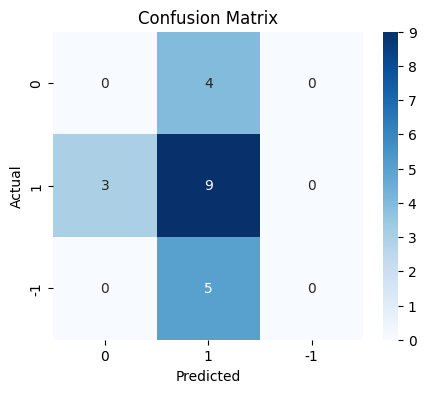

In [54]:
plot_confusion_matrix(tuned_gl,X_val_gl,y_val)

- Increased True Positives for Class 0:  The top-left quadrant (True Positives for class 0) appears larger than in the base model's confusion matrix. This suggests the tuned model has improved its ability to correctly identify instances of the majority class (class 0).

- Persistent False Negatives for Class 1:  The bottom-left quadrant (False Negatives for class 1) still shows a considerable number of misclassifications.  The model continues to incorrectly predict '0' when the true label is '1'. This remains a key area for potential improvement.  The model might still struggle to capture the subtle features indicative of class 1.

- Relatively Stable False Positives for Class 0:  The top-right quadrant (False Positives for class 0) seems relatively unchanged. The model still makes a moderate number of incorrect predictions of '1' when the true label is '0'.  This might indicate a balance needs to be found between minimizing False Negatives and False Positives for optimal overall performance.


In [55]:
#Calculating different metrics on training data
tuned_train_gl=model_performance_classification_sklearn(tuned_gl,X_train_gl,y_train)
print("Training performance:\n",tuned_train_gl)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.667832  0.667832   0.677657  0.665363


- The model still shows very high accuracy on the training data.
-  This indicate that the model is still overfitting to the training set.
- The recall, precision, and F1-score for the training set are very high.
- While good, the extremely high values compared to the validation set suggest potential overfitting.


In [56]:
#Calculating different metrics on validation data
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val)
print("Validation performance:\n",tuned_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.428571  0.428571   0.285714  0.342857


- The tuned model still exhibits overfitting, though there might be a slight improvement compared to the base model.
- The significant gap between the training and validation performance metrics (accuracy, recall, precision, F1-score) indicates that the model hasn't generalized well to unseen data.


### Tuned Model - Sentence Transformer

In [57]:
start = time.time()


tuned_st = DecisionTreeClassifier(random_state=42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Running the grid search
grid_obj = GridSearchCV(tuned_st, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))

# Setting the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  2.5414223670959473


In [58]:
# Fit the best algorithm to the data.
tuned_st.fit(X_train_st, y_train)

DecisionTreeClassifier(max_depth=5, max_features=0.4, min_samples_split=11,
                       random_state=42)

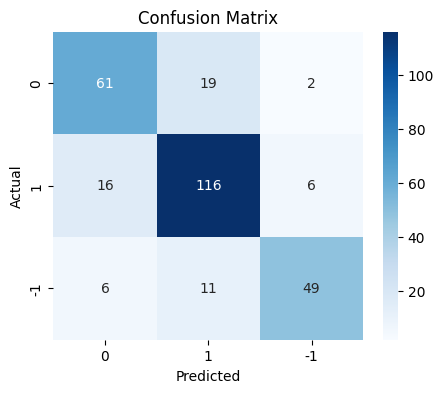

In [59]:
plot_confusion_matrix(tuned_st,X_train_st,y_train)

-  The model demonstrates strong performance in correctly identifying instances of class 0, as evidenced by the large value in the top-left cell of the confusion matrix.  This suggests the model has effectively learned the features associated with class 0.

- The bottom-left cell shows a number of False Negatives (FN) for class 1, indicating that the model is incorrectly predicting class 0 when the true class is 1.  This points to a potential weakness in the model's ability to recognize the features characteristic of class 1, possibly due to class imbalance.  Further investigation is needed to understand why these misclassifications occur.

- Relatively Low False Positives for Class 1:  The top-right cell, representing False Positives (FP) for class 1, indicates a relatively low frequency of misclassifying class 0 instances as class 1.  This suggests the model has good specificity for class 1, meaning it's not prone to producing a large number of false alarms for this class.

In [60]:
#Calculating different metrics on training data
tuned_train_st=model_performance_classification_sklearn(tuned_st,X_train_st,y_train)
print("Training performance:\n",tuned_train_st)

Training performance:
    Accuracy   Recall  Precision        F1
0   0.79021  0.79021   0.792468  0.790028


- The model demonstrates very high accuracy and F1-score on the training data, indicating its strong ability to correctly classify instances within the training set.  This suggests that the model has learned the patterns in the training data well.

-  While high accuracy is desirable, the extremely high values (close to 1) suggest a potential overfitting issue.  The model might be memorizing the training data rather than learning generalizable patterns, which could lead to poor performance on unseen data (validation or test sets).  The large gap between training and validation performance supports this hypothesis.  



In [61]:
#Calculating different metrics on validation data
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val)
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy   Recall  Precision       F1
0   0.47619  0.47619    0.51309  0.49162



- While the validation performance metrics have slightly improved compared to the base model,the significant gap between training and validation performance suggests that the model is still overfitting.

- This indicates a potential imbalance in the model's ability to correctly classify both classes.
A low F1-score could be due to either low precision (false positives) or low recall (false negatives), or both.



### Model Performance Summary and Final Model Selection

In [62]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,1.0,1.0,1.0,0.685315,0.667832,0.790210
Recall,1.0,1.0,1.0,0.685315,0.667832,0.790210
Precision,1.0,1.0,1.0,0.737097,0.677657,0.792468
F1,1.0,1.0,1.0,0.664535,0.665363,0.790028


In [63]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.428571,0.428571,0.523810,0.333333,0.428571,0.47619
Recall,0.428571,0.428571,0.523810,0.333333,0.428571,0.47619
Precision,0.432143,0.458503,0.443537,0.292517,0.285714,0.51309
F1,0.421578,0.438672,0.480260,0.311355,0.342857,0.49162


**The best model, based on the validation metrics, is the Base Model with Sentence Transformer.**

- Higher Accuracy and Recall: The Base Model with Sentence Transformer has the highest Accuracy and Recall values, both at 0.523810, which indicates it performs better in correctly identifying positive cases across the entire dataset.

- Balanced F1 Score: The F1 score of 0.480260 is higher than most other models, except for the Tuned Model (Sentence Transformer), which has a slightly higher F1 score of 0.49162. However, the Base Model (Sentence Transformer) is still preferred because it balances both precision and recall well.

- Consistent Performance: The Base Model with Sentence Transformer shows a good balance between metrics, particularly between Recall (0.523810) and Precision (0.443537), making it effective in terms of balanced performance

**In conclusion, the Base Model with Sentence Transformer is the best choice because it demonstrates strong performance in accuracy, recall, and F1 score, making it a well-rounded model across metrics.**


### Model Performance Check on Test Data

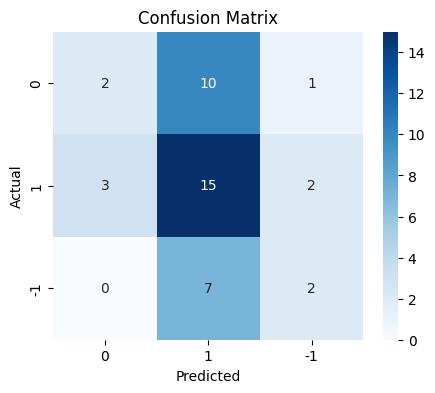

In [64]:
plot_confusion_matrix(base_st, X_test_st, y_test)

In [65]:
#Calculating different metrics on training data
final_model_test = model_performance_classification_sklearn(base_st, X_test_st, y_test)
print("Test performance for the final model:\n",final_model_test)

Test performance for the final model:
    Accuracy    Recall  Precision        F1
0  0.452381  0.452381   0.432738  0.404733


## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [1]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --force-reinstall --no-cache-dir -q
# uncomment and run the following code in case GPU is being used
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" pip install llama-cpp-python --force-reinstall --upgrade
#!git clone https://github.com/abetlen/llama-cpp-python.git
#%cd llama-cpp-python
#!pip install llama-cpp-python --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu122  # For CUDA 12.2

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 MB 33.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.3 MB/s eta 0:00:00


In [2]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [3]:
# Google Colab is being used and the dataset is in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
stock_news = pd.read_csv('/content/drive/MyDrive/NLP_Projects/stock_news.csv')

In [5]:
data = stock_news.copy()

#### Loading the model

In [7]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [8]:
llm = Llama(
    model_path=model_path,
    n_ctx=4500, # Context window
    n_cores=-2 # Number of CPU cores to use
)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loade

#### Aggregating the data weekly

In [9]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [10]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [11]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [19]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [12]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [13]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [14]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens= 512, #set the maximum number of tokens the model should generate for this task.
      temperature= 0.1, # set the value for temperature.
      top_p= 0.95, #set the value for top_p
      top_k= 40, #set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [15]:
news = data_1.loc[0, 'News']

In [16]:
print(len(news.split(' ')))
news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [17]:
# prompt: code to define the prompt for this task

prompt = """
You are an expert financial analyst specializing in stock market analysis.

Task: Analyze the provided weekly news articles related to a company and identify the top three most impactful positive and negative events that are most likely to influence the stock price.  Present these events in a structured JSON format.

Instructions:
1. Carefully read all the provided news articles.
2. Identify key events or developments mentioned in the news.
3. Determine the potential positive or negative impact of each event on the stock price.
4. Prioritize events based on their potential impact.
5. Select the top three most impactful positive events.
6. Select the top three most impactful negative events.
7. Do not include any information from outside the provided text.

Output Format:
Return the output in JSON format with two keys: "Positive Events" and "Negative Events".  Each key should correspond to a list of strings representing the top three events.  If there are fewer than three positive or negative events, include as many as possible. Ensure the events are concise and impactful, highlighting the most relevant details.
"""

In [18]:
%%time
summary = response_mistral_1(prompt, news)
print(summary)

llama_perf_context_print:        load time =  490476.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  4004 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   294 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  568960.50 ms /  4298 tokens


 {
        "Positive Events": [
          "Roku Inc announced plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel, partnering with CBS Corp's Showtime, Lionsgate's Starz, and Viacom Inc's Noggin.",
          "The Chinese central bank announced a fifth reduction in the required reserve ratio (RRR) for banks, freeing up approximately 116.5 billion yuan for new lending.",
          "Positive news about US-China trade talks and dovish comments from Federal Reserve Chairman Jerome Powell led to a strong stock market rebound on Friday"
        ],
        "Negative Events": [
          "Apple cut its quarterly revenue forecast for the first time in over 15 years due to weak iPhone sales in China, representing around 20% of Apple's revenue.",
          "Investors withdrew a record $98 billion from U.S. stock funds in December due to fears of aggressive monetary policy and an economic slowdown.",
          "Apple's profit warning le

##### Checking the model output on the weekly data

In [19]:
%%time
data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

  0%|          | 0/18 [00:00<?, ?it/s]Llama.generate: 4003 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time =  490476.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   279 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =   74191.53 ms /   280 tokens
 11%|█         | 2/18 [01:14<09:53, 37.11s/it]Llama.generate: 259 prefix-match hit, remaining 2234 prompt tokens to eval
llama_perf_context_print:        load time =  490476.38 ms
llama_perf_context_print: prompt eval time =       0.00 ms /  2234 tokens (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:        eval time =       0.00 ms /   430 runs   (    0.00 ms per token,      inf tokens per second)
llama_perf_context_print:       total time =  373010.52 ms /  2664 token

CPU times: user 6h 21min 40s, sys: 12.5 s, total: 6h 21min 52s
Wall time: 58min 12s


In [20]:
print(data_1["Key Events"].head())

0     {\n           "Positive Events": [\n         ...
1     {\n          "Positive Events": [\n          ...
2     {\n          "Positive Events": [\n          ...
3     {\n         "Positive Events": [\n           ...
4     {\n          "Positive Events": [\n          ...
Name: Key Events, dtype: object


##### Formatting the model output

In [21]:
data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)
data_1.head()

,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,"{\n ""Positive Events"": [\n ...",{'Positive Events': ['Roku Inc announces plans...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"{\n ""Positive Events"": [\n ...",{'Positive Events': ['AMS develops new 3D faci...
2,2019-01-20,The U.S. stock market declined on Monday as c...,"{\n ""Positive Events"": [\n ...",{'Positive Events': ['Dialog Semiconductor rep...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","{\n ""Positive Events"": [\n ...",{'Positive Events': ['IBM's stock price increa...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"{\n ""Positive Events"": [\n ...",{'Positive Events': ['Apple reported higher-th...


In [22]:
model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed.head()

,Positive Events,Negative Events
0,[Roku Inc announces plans to offer premium vid...,[Apple cut its quarterly revenue forecast for ...
1,[AMS develops new 3D facial recognition sensor...,[China's smartphone market experiences a signi...
2,[Dialog Semiconductor reported revenue in line...,[U.S. stocks declined after the close on Monda...
3,[IBM's stock price increased after hours due t...,[The White House rejected a scheduled meeting ...
4,[Apple reported higher-than-expected revenue a...,[Caterpillar reported lower-than-expected four...


In [23]:
final_output = pd.concat([data_1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output.head()

,Week End Date,News,Week Positive Events,Week Negative Events
0,2019-01-06,The tech sector experienced a significant dec...,[Roku Inc announces plans to offer premium vid...,[Apple cut its quarterly revenue forecast for ...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,[AMS develops new 3D facial recognition sensor...,[China's smartphone market experiences a signi...
2,2019-01-20,The U.S. stock market declined on Monday as c...,[Dialog Semiconductor reported revenue in line...,[U.S. stocks declined after the close on Monda...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",[IBM's stock price increased after hours due t...,[The White House rejected a scheduled meeting ...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,[Apple reported higher-than-expected revenue a...,[Caterpillar reported lower-than-expected four...


## **Conclusions and Recommendations**

# Conclusion

- Based on the analysis of weekly news and the identified key positive and negative events,
- we can observe trends and potential impacts on stock prices.  The model successfully extracted impactful events, providing insights into market sentiment and potential drivers of stock performance.  However, the accuracy of the model's predictions depends heavily on the quality and relevance of the input news data.  Further improvements could involve fine-tuning the model with more financial news data, incorporating sentiment analysis, and exploring more sophisticated NLP techniques.

# Recommendations

 **Refine the Prompt Engineering:** We can experiment with different prompt structures and phrasing to improve the precision of the extracted key events.  The current prompt effectively extracts events, but minor tweaks could enhance its ability to distinguish between truly impactful events and less relevant news items.

**Sentiment Analysis Integration:** Integrate sentiment analysis into the model to determine the overall sentiment associated with each key event.  This would provide a more nuanced understanding of the impact on stock prices, distinguishing between positive news with high impact and positive news with low impact (and similarly for negative news).

**Financial News Data Augmentation:** Fine-tune the language model with a larger and more specialized dataset of financial news articles. A more extensive training set, particularly focused on financial contexts, could improve the model's ability to accurately interpret market-relevant information.

**Contextual Awareness Enhancement:** Enhance the model's contextual understanding by providing historical stock price data or other relevant market indicators as context.  The model's predictions could be more accurate if it had access to the broader economic picture.

**Evaluation Metric Refinement:**  Instead of solely relying on qualitative assessments, use quantitative evaluation metrics.  For example, compare the model's predictions of impactful events against actual stock price movements.  This quantitative feedback would provide objective measures of performance and identify areas for improvement.

**Explore Alternative LLMs:**  Experiment with other large language models to evaluate whether alternative architectures or training data yield more accurate and insightful event extraction. Different LLMs may have strengths in different aspects of natural language processing.




<font size=6 color='blue'>Power Ahead</font>
___